In [ ]:
import pandas as pd
import csv
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import re
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install picos

     |████████████████████████████████| 320 kB 13.7 MB/s 
  Created wheel for picos: filename=PICOS-2.2.55-py3-none-any.whl size=448519 sha256=d90cd61d298bc61d1ffc51694e03165a141723ba93ae6fd6886f678f8e637971
  Stored in directory: /root/.cache/pip/wheels/9b/5f/db/daac50b3d79b174bb82421b89e5724512468df6982695a4c70
Successfully built picos


In [ ]:
#!/usr/bin/env python
# Copyright (c) 2014 - 2018  Mateo Rojas-Carulla  [mrojascarulla@gmail.com]
# All rights reserved.  See the file COPYING for license terms.

import autograd.numpy as np_aut
import autograd

import numpy as np
import scipy as sc
from scipy import io
from scipy.spatial.distance import pdist, squareform
import sys
import time

from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from matplotlib import pyplot as pl
from matplotlib import rc
import matplotlib as mpl

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
import os

import pickle
import picos as pic
from cvxopt import matrix, solvers

def split_train_valid(x, y, n_ex, valid_split=0.1):
    n_ex_cum = np.append(0, np.cumsum(n_ex))
    n_ex_train, n_ex_valid = [], []
    train_x, train_y, valid_x, valid_y = [], [], [], []

    for i in range(len(n_ex)):
        n_train_task = int((1 - valid_split) * n_ex[i])
        train_x.append(x[n_ex_cum[i]:n_ex_cum[i] + n_train_task])
        train_y.append(y[n_ex_cum[i]:n_ex_cum[i] + n_train_task])

        valid_x.append(x[n_ex_cum[i] + n_train_task:n_ex_cum[i + 1]])
        valid_y.append(y[n_ex_cum[i] + n_train_task:n_ex_cum[i + 1]])
        
        n_ex_train.append(n_train_task)
        n_ex_valid.append(n_ex[i] - n_train_task)

    train_x = np.concatenate(train_x, 0)
    valid_x = np.concatenate(valid_x, 0)
    train_y = np.concatenate(train_y, 0)
    valid_y = np.concatenate(valid_y, 0)

    n_ex_train = np.array(n_ex_train)
    n_ex_valid = np.array(n_ex_valid)

    return train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid



def np_getDistances(x,y):
    K = (x[:,:, np.newaxis] - y.T)
    return np.linalg.norm(K,axis = 1)

    
#Select top 11 predictors from Lasso
def lasso_alpha_search_synt(X,Y):

    exit_loop = False
    alpha_lasso = 0.2
    step = 0.02
    num_iters = 1000
    count = 0
    n = 11

    while(not exit_loop and count < num_iters):
            count = count + 1

            regr = linear_model.Lasso(alpha = alpha_lasso)
            regr.fit(X,Y.flatten())
            zeros =  np.where(np.abs(regr.coef_) < 0.00000000001)

            nonzeros = X.shape[1]-zeros[0].shape[0]

            if(nonzeros >= n and nonzeros<n+1):
                    exit_loop = True
            if nonzeros<n:
                    alpha_lasso -= step
            else:
                    step /= 2
                    alpha_lasso += step


    mask = np.ones(X.shape[1],dtype = bool)
    mask[zeros] = False
    genes = []
    index_mask = np.where(mask == True)[0]

    return mask



#Given a number of training tasks, the total number of examples and the number per task, return a boolean mask (for SMTL)
def mask_training_tasks(n_tasks,n_s,n_tot,n_pred):
    mask = np.zeros((n_tot,n_pred),dtype = bool)
    n_each = n_tot/n_tasks
    for t in range(n_tasks):
        mask[t*n_each:t*n_each+n_s,:] = True
    return mask


#-------------------------------------------------------------------------------
# Run and SDP to find a feasible solution when optimising (4)
#-----------------------------------------------------------------------------

def find_init_sol(Cov_ctr,s_size, n_size):

    shape = Cov_ctr.shape[0]
    sdp = pic.Problem()
    X = sdp.add_variable('X', (shape,shape), vtype='symmetric')
    Cov_ctr = pic.new_param('M', matrix(Cov_ctr))

    #Matrix has to be spd
    sdp.add_constraint(X>>0)
    for i in range(shape):
        for j in range(i+1):
            if i==shape-1 and j>=s_size and j<shape-1:
                continue
            else:
                sdp.add_constraint(X[i,j] == Cov_ctr[i,j])

    sdp.set_objective('min',0*sum(X))
    sol = sdp.solve(solver = 'cvxopt', verbose = False)
    X = np.array(X.value)

    return X
 
def find_init_sol_b(Cov_ctr, fix):

    shape = Cov_ctr.shape[0]
    sdp = pic.Problem()
    X = sdp.add_variable('X', (shape,shape), vtype='symmetric')
    Cov_ctr = pic.new_param('M', matrix(Cov_ctr))

    #Matrix has to be spd
    sdp.add_constraint(X>>0)

    for i in range(shape-fix, shape):
        for j in range(shape-fix, shape):
          sdp.add_constraint(X[i,j] == Cov_ctr[i,j])

    sdp.set_objective('min', 0*sum(X))
    sol = sdp.solve(solver = 'cvxopt', verbose = True)
    X = np.array(X.value)

    return X

#---------------------------------------------------------------------------
# Compute beta for the naive plug-in estimator
#---------------------------------------------------------------------------

def compute_beta_naive(X,X_l,Y_l,S,alpha,eps,numCauses, X_tr = 0, Y_tr = 0):

    ns_l = X.shape[0]
    ns_s = Y_l.size

    
    numEffects = X.shape[1]-numCauses
    numPredictors = X.shape[1]
    
    cov_x = 1./ns_l*np.dot(X.T,X)
    cov_xs = cov_x[0:numCauses,0:numCauses]
    
    cov_ys = np.dot(cov_xs,alpha)

    cov_yn = 1./ns_s*np.dot(X_l[:,numCauses:].T,Y_l)
    cov_xy = np.append(cov_ys, cov_yn)[:,np.newaxis]
    
    cy = np.dot(alpha[np.newaxis,:],
                np.dot(cov_xs,alpha[:,np.newaxis])) + eps**2
        
    cov_y = np.concatenate([cov_xy,cy]).T
        
    temp = np.append(cov_x,cov_xy.T,axis=0)
    cov = np.append(temp,cov_y.T,axis=1)

    cov_x = cov[0:-1,0:-1]
    cov_xy = cov[-1,0:-1][:,np.newaxis]

    beta_est =  np.dot(np.linalg.inv(cov_x),cov_xy)

    return beta_est

#--------------------------------------------------------------------
# Maximize (4) and return beta
#-------------------------------------------------------------------

def compute_beta_mtl(X,X_l,Y_l,S,alpha,eps,numCauses,X_tr = 0,
                     Y_tr = 0, opti_alpha = False,
                     true_cov = None):

    ns_l = X.shape[0]
    ns_s = Y_l.size
    
    numEffects = X.shape[1]-numCauses
    numPredictors = X.shape[1]

    if true_cov ==None:
        cov_x = np.cov(X.T)
    else:
        cov_x = true_cov[0:-1,0:-1]
        

    if numCauses == numPredictors:
        cov_xs = cov_x[0:numCauses,0:numCauses]
        cov_ys = np.dot(cov_xs,alpha)
        cov_xy = cov_ys[:,np.newaxis]
        cy = np.dot(alpha[np.newaxis,:],
                np.dot(cov_xs,alpha[:,np.newaxis])) + eps**2

        cov_y = np.concatenate([cov_xy,cy]).T
        temp = np.append(cov_x,cov_xy.T,axis=0)
        cov = np.append(temp,cov_y.T,axis=1)

        cov_x = cov[0:-1,0:-1]
        cov_xy = cov[-1,0:-1][:,np.newaxis]
        
        beta_est =  np.dot(np.linalg.inv(cov_x),cov_xy)
        return beta_est

    
    elif numCauses ==0:
        cov_xy = 1./ns_s*np.dot(X_l[:,numCauses:].T,Y_l)
        cov_yn = cov_xy
        cy = np.array([eps**2])[:,np.newaxis]
        
    else:
        cov_xs = cov_x[0:numCauses,0:numCauses]
        cov_ys = np.dot(cov_xs,alpha)
        cov_yn = 1./ns_s*np.dot(X_l[:,numCauses:].T,Y_l)

        cov_xy = np.append(cov_ys, cov_yn)[:,np.newaxis]
        cy = np.dot(alpha[np.newaxis,:],
                    np.dot(cov_xs,alpha[:,np.newaxis])) + eps**2

    
    cov_y = np.concatenate([cov_xy,cy]).T
    temp = np.append(cov_x,cov_xy.T,axis=0)
    x = cov_yn

    M = np.append(temp,cov_y.T,axis=1)
    
    def logl_chol(u):
        
        Mat = M

        Mat[-1,numCauses:-1] = u
        Mat[numCauses:-1,-1] = u.T
        
        try:
            M_inv = np_aut.linalg.inv(Mat)
            det = np_aut.linalg.det(M_inv)
            if np_aut.isnan(det) or det<0:
                log_det = -1e5
            else: log_det = np_aut.log(det)
            
            ret = np_aut.trace(np_aut.dot(M_inv,S)) - log_det
            
        except Exception:
            ret = 1e5
    
        return ret
    
        
    cov= find_init_sol(M,numCauses,numEffects)
    M[-1,numCauses:-1] = cov[-1,numCauses:-1]
    
    x_init = M[-1,numCauses:-1]
    tol= 1e-10
    res = sc.optimize.fmin(logl_chol,x_init,
                            xtol = tol,
                            ftol = tol,
                            maxiter = 1e5,
                            maxfun = 3e5,
                            disp = False)

    M[-1,numCauses:-1] = res
    M[numCauses:-1,-1] = res.T
    
    cov[-1,numCauses:-1] = M[-1,numCauses:-1]
    cov[numCauses:-1,-1] = M[numCauses:-1,-1]    
    cov_x = cov[0:-1,0:-1]
    cov_xy = cov[-1,0:-1][:,np.newaxis]

    beta_est =  np.dot(np.linalg.inv(cov_x),cov_xy)

    return beta_est


#----------------------------------------------------------------------------
#Return MTL coefficient for both the naive and the approach maximizing (4)
#----------------------------------------------------------------------------

def error_naive_beta(train_x, train_y,
                   X_lab,Y_lab,
                   X_ul,test_x,test_y,
                   subset,cov,n,p, alpha=np.zeros(1), eps=0,min_el = 0):

    if eps==0:
        train_x_all = np.append(train_x, X_lab, axis=0)
        train_y_all = np.append(train_y, Y_lab, axis=0)
        regr = linear_model.LinearRegression()
        regr.fit(train_x_all[:,subset],train_y_all)
        pred = regr.predict(train_x_all[:,subset])
        alpha = regr.coef_
        eps = np.std(train_y_all-pred)

    else:
        alpha = alpha
        eps = eps
    
    mask = np.ones(p, dtype = bool)

    mask[subset] = False

    s_size = subset.size

    X_lab_perm = np.concatenate([X_lab[:,subset],X_lab[:,mask]],axis=1)
    X_ul_perm = np.concatenate([X_ul[:,subset],X_ul[:,mask]],axis=1)

    cov = np.concatenate([X_lab_perm, Y_lab], axis=1)
    cov = 1./n*np.dot(cov.T,cov)
                             
    beta = compute_beta_naive(np.append(X_lab_perm, X_ul_perm,axis=0),
                            X_lab_perm,
                            Y_lab,
                            cov,
                            alpha.flatten(),
                            eps,
                            s_size,
                            train_x,
                            train_y)

    bs = beta[0:s_size].flatten()
    bn  = beta[s_size:].flatten()
    
    if min_el != 0:
        n = min_el

    pred_test = np.sum(bs*test_x[:,subset],axis=1) + np.sum(bn*test_x[:,mask],1)
    pred_test = pred_test[:,np.newaxis]
    
    mse_test =np.mean((pred_test-test_y)**2)
    if subset.size > 0 and subset.size<p:
        b = np.zeros(p)
        b[subset] = bs
        b[mask] = bn
    else:
        b = beta.flatten()

    return mse_test, b[:,np.newaxis]


def error_mle_beta(train_x, train_y,
                   X_lab,Y_lab,
                   X_ul,test_x,test_y,
                   subset,cov,n,p, alpha=np.zeros(1), eps=0,min_el = 0,
                   opti_alpha = False,
                   true_cov = None):

    if eps==0:
        train_x_all = np.append(train_x, X_lab, axis=0)
        train_y_all = np.append(train_y, Y_lab, axis=0)
        
        if subset.size > 0:
            regr = linear_model.LinearRegression()
            regr.fit(train_x_all[:,subset],train_y_all)
            pred = regr.predict(train_x_all[:,subset])
            alpha = regr.coef_.flatten()
            eps = np.std(train_y_all-pred)

        else:
            alpha = np.zeros(1)
            eps = np.std(train_y_all)

    else:
        alpha = alpha
        eps = eps

    mask = np.ones(p, dtype = bool)
    if subset.size>0:
        mask[subset] = False

    s_size = subset.size
    if s_size > 0:
        X_lab_perm = np.concatenate([X_lab[:,subset],X_lab[:,mask]],axis=1)
        X_ul_perm = np.concatenate([X_ul[:,subset],X_ul[:,mask]],axis=1)
    else:
        X_lab_perm = X_lab
        X_ul_perm = X_ul

    cov = np.concatenate([X_lab_perm, Y_lab], axis=1)
    cov = np.cov(cov.T)
    
    beta = compute_beta_mtl(np.append(X_lab_perm, X_ul_perm,axis=0),
                            X_lab_perm,
                            Y_lab,
                            cov,
                            alpha.flatten(),
                            eps,
                            s_size,
                            train_x,
                            train_y,
                            opti_alpha,
                            true_cov)

    bs = beta[0:s_size].flatten()
    bn  = beta[s_size:].flatten()
    
    #if min_el != 0:
        #n = min_el

    if subset.size>0:
        pred_test = np.sum(bs*test_x[:,subset],axis=1)+ np.sum(bn*test_x[:,mask],1)
    else: pred_test = np.sum(bn*test_x[:,mask],1)
    pred_test = pred_test[:,np.newaxis]
    
    mse_test =np.mean((pred_test-test_y)**2)

    if subset.size > 0 and subset.size<p:
        b = np.zeros(p)
        b[subset] = bs
        b[mask] = bn
    else:
        b = beta.flatten()

    return mse_test, b[:,np.newaxis]

    
def error_mle_beta_cv(train_x, train_y,
                   X_lab_all, Y_lab_all,
                   X_ul,
                   subset_list,cov,n,p, 
                   alpha=np.zeros(1), eps=0,min_el = 0,
                   opti_alpha = False,
                   true_cov = None):

    scores = []
    fold = 5

    kf = KFold(X_lab_all.shape[0], n_folds = fold)

    for subset in subset_list:
      scores_temp = []

      for train, test in kf:
        X_lab = X_lab_all[train]
        Y_lab = Y_lab_all[train]
        n = X_lab.shape[0]

        if eps==0:
            train_x_all = np.append(train_x, X_lab, axis=0)
            train_y_all = np.append(train_y, Y_lab, axis=0)
            
            if subset.size > 0:
                regr = linear_model.LinearRegression()
                regr.fit(train_x_all[:,subset],train_y_all)
                pred = regr.predict(train_x_all[:,subset])
                alpha = regr.coef_.flatten()
                eps = np.std(train_y_all-pred)

            else:
                alpha = np.zeros(1)
                eps = np.std(train_y_all)

        else:
            alpha = alpha
            eps = eps

        mask = np.ones(p, dtype = bool)
        if subset.size>0:
            mask[subset] = False

    
        s_size = subset.size
        if s_size > 0:
            X_lab_perm = np.concatenate([X_lab[:,subset],X_lab[:,mask]],axis=1)
            X_ul_perm = np.concatenate([X_ul[:,subset],X_ul[:,mask]],axis=1)
        else:
            X_lab_perm = X_lab
            X_ul_perm = X_ul

        cov = np.concatenate([X_lab_perm, Y_lab], axis=1)
        cov = np.cov(cov.T)
        
        beta = compute_beta_mtl(np.append(X_lab_perm, X_ul_perm,axis=0),
                                X_lab_perm,
                                Y_lab,
                                cov,
                                alpha.flatten(),
                                eps,
                                s_size,
                                train_x,
                                train_y,
                                opti_alpha,
                                true_cov)

        bs = beta[0:s_size].flatten()
        bn  = beta[s_size:].flatten()
        
        test_x, test_y = X_lab_all[test], Y_lab_all[test]

        if subset.size>0:
            pred_test = np.sum(bs*test_x[:,subset],axis=1)+ np.sum(bn*test_x[:,mask],1)
        else: pred_test = np.sum(bn*test_x[:,mask],1)
        pred_test = pred_test[:,np.newaxis]
        
        mse_test =np.mean((pred_test-test_y)**2)

        if subset.size > 0 and subset.size<p:
            b = np.zeros(p)
            b[subset] = bs
            b[mask] = bn
        else:
            b = beta.flatten()
        scores_temp.append(mse_test)
        eps = 0
      scores.append(np.mean(scores_temp))

    return subset_list[np.argmin(scores)]


def np_getDistances(x,y):
	K = (x[:,:, np.newaxis] - y.T)
	return np.linalg.norm(K,axis = 1)

def np_gaussian_kernel(x,y, beta=0.1):
    K = np_outer_substract(x,y)
    return np.exp( -beta * np.linalg.norm(K, axis=1))

def mat_hsic(X,nEx):

	nExCum = np.cumsum(nEx)
	domains = np.zeros((np.sum(nEx),np.sum(nEx)))
	currentIndex = 0

	for i in range(nEx.size):

		domains[currentIndex:nExCum[i], currentIndex:nExCum[i]] = np.ones((nEx[i], nEx[i]))
		currentIndex = nExCum[i]

	return domains

def numpy_GetKernelMat(X,sX):

	Kernel = (X[:,:, np.newaxis] - X.T).T
	Kernel = np.exp( -1./(2*sX) * np.linalg.norm(Kernel, axis=1))

	return Kernel

def numpy_HsicGammaTest(X,Y, sigmaX, sigmaY, DomKer = 0):

	n = X.T.shape[1]

	KernelX = numpy_GetKernelMat(X,sigmaX)

	KernelY = DomKer

	coef = 1./n
	HSIC = coef**2*np.sum(KernelX*KernelY) + coef**4*np.sum(
                KernelX)*np.sum(KernelY) - 2*coef**3*np.sum(np.sum(KernelX,axis=1)*np.sum(KernelY, axis=1))
	
	#Get sums of Kernels
	KXsum = np.sum(KernelX)
	KYsum = np.sum(KernelY)

	#Get stats for gamma approx

	xMu = 1./(n*(n-1))*(KXsum - n)
	yMu = 1./(n*(n-1))*(KYsum - n)
	V1 = coef**2*np.sum(KernelX*KernelX) + coef**4*KXsum**2 - 2*coef**3*np.sum(np.sum(KernelX,axis=1)**2)
	V2 = coef**2*np.sum(KernelY*KernelY) + coef**4*KYsum**2 - 2*coef**3*np.sum(np.sum(KernelY,axis=1)**2)

	meanH0 = (1. + xMu*yMu - xMu - yMu)/n
	varH0 = 2.*(n-4)*(n-5)/(n*(n-1.)*(n-2.)*(n-3.))*V1*V2

	#Parameters of the Gamma
	a = meanH0**2/varH0
	b = n * varH0/meanH0

	return n*HSIC, a, b


def sigmoid(x):
	return 1./(1+np.exp(-x))

#--------------------------------------------------------
#Process residuals for computing a Levene test
#-------------------------------------------------------

def levene_pval(Residual,nEx, numR):
	
	prev = 0 
	n_ex_cum = np.cumsum(nEx)

	for j in range(numR):

		r1 = Residual[prev:n_ex_cum[j]]

		if j == 0:
			residTup = (r1,)

		else:
			residTup = residTup + (r1,)

		prev = n_ex_cum[j]

	return residTup


#----------------------------------------------------------------------------
# Utils for Dica
#--------------------------------------------------------------------------

def get_kernel_mat(x,y, sx2):
    K = (x[:,:, np.newaxis] - y.T)
    return np.exp(-1./(2*sx2)*np.linalg.norm(K,axis = 1)**2)

def get_kernel_mat_lin(x,y, sx2):
    K = (x[:,:, np.newaxis]*y.T)
    return np.sum(K,axis=1)

def np_getDistances(x,y):
	K = (x[:,:, np.newaxis] - y.T)
	return np.linalg.norm(K,axis = 1)


def get_color_dict():

  colors = {
    'pool' : 'red',
    'lasso' : 'red',
    'shat' : 'green',
    'sgreed' : 'green',
    'ssharp' : 'green',
    'strue' : 'blue',
    'cauid' : 'blue',
    'causharp': 'blue',
    'cauul' : 'blue',
    'mean' : 'black',
    'msda' : 'orange',
    'mtl' : 'orange',
    'dica' : 'orange',
    'dom' : 'k',
    'naive' : 'magenta'
  }

  markers = {
    'pool' : 'o',
    'lasso' : '^',
    'shat' : 'o',
    'sgreed' : '^',
    'strue' : '^',
    'ssharp' : 'd',
    'cauid' : 'd',
    'causharp' : 'h',
    'cauul' : '^',
    'mean' : 'o',
    'msda' : 'o',
    'mtl' : '^',
    'dica' : 'd',
    'dom' : 'o',
    'naive' : 'o'
  }

  legends = {
              'pool' : r'$\beta^{CS}$',
              'lasso' : r'$\beta^{CS(\hat S Lasso)}$',
              'shat' : r'$\beta^{CS(\hat S)}$',
              'ssharp' : r'$\beta^{CS(\hat S \sharp)}$',
              'strue' : r'$\beta^{CS(cau)}$',
              'cauid' : r'$\beta^{CS(cau+,id)}$',
              'causharp' : r'$\beta^{CS(cau\sharp)}$',
              'cauul' : r'$\beta^{CS(cau\sharp UL)}$',
              'sgreed' :r'$\beta^{CS(\hat{S}_{greedy})}$',
              'mean'   : r'$\beta^{mean}$',
              'msda'   : r'$\beta^{mSDA}$',
              'mtl'   : r'$\beta^{MTL}$',
              'dica'   : r'$\beta^{DICA}$',
              'naive'   : r'$\beta^{naive}$',
              'dom'   : r'$\beta^{dom}$'
            }

  return colors, markers, legends

def mse(model, x, y):
  return np.mean((model.predict(x)-y)**2)


def intervene_on_p(l_p, sz):
  mask = np.zeros((sz, 1), dtype = bool)
  if len(l_p) > 0:
    mask[l_p] = True
  return mask


def merge_results(f1, f2, key, direc):
  with open(os.path.join(direc, f1), 'rb') as f:
    r1 = pickle.load(f)
  with open(os.path.join(direc, f2), 'rb') as f:
    r2 = pickle.load(f)

  r1['results'][key] = r2['results'][key]
  if key not in r1['plotting'][0]:
      r1['plotting'][0].append(key)

  with open(os.path.join(direc, 'merged.pkl'),'wb') as f:
    pickle.dump(r1, f)


################### CLASSIFICATION

In [ ]:
# ALARM DATASET

# Training data 1 domain
df = pd.read_csv("/content/drive/MyDrive/ANDES_DATA.csv")
df = df.drop(columns = df.columns[0])
df = df.apply(LabelEncoder().fit_transform)

df = df.drop(['LVFAILURE','HYPOVOLEMIA','HISTORY','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)


n_examples_task = 500
n_tasks = 2
n_test_tasks = 1
n_predictors = 21
n_ex = []

for i in range(n_tasks):
    n_ex.append(n_examples_task)


n_ex = np.array(n_ex)

## Taking ARTCO2 as target
# train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df.drop(["ARTCO2"], axis = 1 ), df["ARTCO2"], n_ex,0.5)

## Taking EXPCO2 as target
train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df.drop(["EXPCO2"], axis = 1 ), df["EXPCO2"], n_ex,0.5)

In [ ]:
# ALARM DATASET

# Training data + soft INT as  training
le = LabelEncoder()
df = pd.read_csv("/content/drive/MyDrive/ANDES_DATA.csv")
df = df.drop(columns = df.columns[0])
df = df.apply(le.fit_transform)

df = df.drop(['LVFAILURE','HYPOVOLEMIA','HISTORY','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)


df2 = pd.read_csv("/content/drive/MyDrive/alarm_soft.csv")
df2 = df2.drop(columns = df2.columns[0])
df2 = df2.apply(le.fit_transform)

df2 = df2.drop(['LVFAILURE','HYPOVOLEMIA','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)

df2 = df2.append(df)

n_examples_task = 1000
n_tasks = 2
n_test_tasks = 1
n_predictors = 21
n_ex = []

for i in range(n_tasks):
    n_ex.append(n_examples_task)


n_ex = np.array(n_ex)

## Taking ARTCO2 as target
# train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df2.drop(["ARTCO2"], axis = 1 ), df2["ARTCO2"], n_ex,0.5)

## Taking EXPCO2 as target
train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df2.drop(["EXPCO2"], axis = 1 ), df2["EXPCO2"], n_ex,0.5)

In [ ]:
import numpy as np
import scipy as sp
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
import itertools
import sys

use_hsic = False 
delta = 0.05

num_s = np.sum(n_ex)

num_predictors = train_x.shape[1]
best_subset = np.array([])
best_subset_acc = np.array([])
best_mse_overall = 1e10

already_acc = False

selected = np.zeros(num_predictors)
accepted_subset = None

all_sets, all_pvals = [], []


n_iters = 10*num_predictors
stay = 1

pow_2 = np.array([2**i for i in np.arange(num_predictors)])

ind = 0
prev_stat = 0

bins = []

#Get numbers for the mean

pred = np.mean(train_y)
mse_current = np.mean((pred - valid_y) ** 2)
residual = valid_y - pred
 #   residTup = np.array(residTup).flatten()
residTup = levene_pval(residual,n_ex_valid,n_ex_valid.size)

levene = sp.stats.levene(*residTup)

all_sets.append(np.array([]))
all_pvals.append(levene[1])

alpha = 0.05

if all_pvals[-1]>alpha:
  accepted_subset = np.array([])

while (stay==1):
    
    pvals_a = np.zeros(num_predictors)
    statistic_a = 1e10 * np.ones(num_predictors)
    mse_a = np.zeros(num_predictors)
    
    for p in range(num_predictors):
        current_subset = np.sort(np.where(selected == 1)[0])
        regr = linear_model.LinearRegression()
        
        if selected[p]==0:
            subset_add = np.append(current_subset, p).astype(int)
            regr.fit(train_x[:,subset_add], train_y.flatten())
            
            pred = regr.predict(valid_x[:,subset_add])[:,np.newaxis]
            mse_current = np.mean((pred - valid_y)**2)
            residual = (np.array(valid_y).flatten() - np.array(pred).flatten())
            
            residTup = levene_pval(residual,n_ex_valid,
                                                 n_ex_valid.size)
            # print(residual.shape)
            levene = sp.stats.levene(*residTup)
            
            pvals_a[p] = levene[1]
            statistic_a[p] = levene[0]
            mse_a[p] = mse_current
            
            all_sets.append(subset_add)
            all_pvals.append(levene[1])
        
        if selected[p] == 1:
            acc_rem = np.copy(selected)
            acc_rem[p] = 0
            
            subset_rem = np.sort(np.where(acc_rem == 1)[0])
            
            if subset_rem.size ==0: continue
            
            regr = linear_model.LinearRegression()
            regr.fit(train_x[:,subset_rem], train_y.flatten())
            
            pred = regr.predict(valid_x[:,subset_rem])[:,np.newaxis]
            mse_current = np.mean((pred - valid_y)**2)
            residual = (np.array(valid_y).flatten() - np.array(pred).flatten())
            
            residTup = levene_pval(residual,n_ex_valid, 
                                                 n_ex_valid.size)
            levene = sp.stats.levene(*residTup)
            
            pvals_a[p] = levene[1]
            statistic_a[p] = levene[0]
            mse_a[p] = mse_current
            
            all_sets.append(subset_rem)
            all_pvals.append(levene[1])
    
    accepted = np.where(pvals_a > alpha)
    
    if accepted[0].size>0:
        best_mse = np.amin(mse_a[np.where(pvals_a > alpha)])
        already_acc = True
        
        selected[np.where(mse_a == best_mse)] = \
          (selected[np.where(mse_a == best_mse)] + 1) % 2
        
        accepted_subset = np.sort(np.where(selected == 1)[0])
        binary = np.sum(pow_2 * selected)
        
        if (bins==binary).any():
            stay = 0
        bins.append(binary)
    else:
        best_pval_arg = np.argmin(statistic_a)
        
        selected[best_pval_arg] = (selected[best_pval_arg] + 1) % 2
        binary = np.sum(pow_2 * selected)
        
        if (bins==binary).any():
            stay = 0
        bins.append(binary)
    
    if ind>n_iters:
        stay = 0
    ind += 1


if accepted_subset is None:
  all_pvals = np.array(all_pvals).flatten()
  
  max_pvals = np.argsort(all_pvals)[-1]
  accepted_subset = np.sort(all_sets[max_pvals])

In [ ]:
accepted_subset

array([ 0,  1,  2,  3,  4,  5,  6,  9, 12, 13, 14, 15, 17])

In [ ]:
accepted

(array([], dtype=int64),)

In [ ]:
# df2.drop(['EXPCO2'], axis=1)
df.drop(['ARTCO2'], axis=1) [ 1,  2,  3,  4, 11, 13, 14, 16, 17, 18, 20]

,INSUFFANESTH,ANAPHYLAXIS,TPR,EXPCO2,KINKEDTUBE,MINVOL,FIO2,PVSAT,SAO2,PAP,PULMEMBOLUS,SHUNT,INTUBATION,PRESS,DISCONNECT,MINVOLSET,VENTMACH,VENTTUBE,VENTLUNG,VENTALV,CATECHOL
0,0,0,2,1,0,3,1,1,1,2,0,1,1,0,0,2,2,1,3,3,0
1,0,0,2,1,0,3,1,1,1,2,0,1,1,2,0,2,2,1,3,3,0
2,0,0,2,1,0,3,1,1,1,2,0,1,1,0,0,2,2,1,3,3,0
3,0,0,2,1,0,3,1,1,1,2,0,1,1,1,0,2,2,1,3,3,0
4,0,0,1,1,0,0,1,0,0,2,0,1,1,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,0,3,1,1,0,2,0,1,1,0,1,2,2,3,3,3,0
996,0,0,2,1,0,3,1,1,1,2,0,1,1,0,0,2,2,1,3,3,0
997,0,0,1,1,0,3,0,1,1,2,0,1,1,0,0,2,2,1,3,3,0
998,0,0,0,1,0,3,1,1,1,2,0,1,1,0,0,2,2,1,3,3,0


Baselines

In [ ]:
# ALARM 
# # Training data 1 domain
# df = pd.read_csv("/content/drive/MyDrive/ANDES_DATA.csv")
# df = df.drop(columns = df.columns[0])
# df = df.apply(LabelEncoder().fit_transform)

# df = df.drop(['LVFAILURE','HYPOVOLEMIA','HISTORY','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)



# TRAINING + SOFT INT DATA
le = LabelEncoder()
df = pd.read_csv("/content/drive/MyDrive/ANDES_DATA.csv")
df = df.drop(columns = df.columns[0])
df = df.apply(le.fit_transform)

df = df.drop(['LVFAILURE','HYPOVOLEMIA','HISTORY','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)


df2 = pd.read_csv("/content/drive/MyDrive/alarm_soft.csv")
df2 = df2.drop(columns = df2.columns[0])
df2 = df2.apply(le.fit_transform)

df2 = df2.drop(['LVFAILURE','HYPOVOLEMIA','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)

df2 = df2.append(df)
df = df2

# # ECO2 TARGET
# X_train,X_test,y_train,y_test = train_test_split(df['KINKEDTUBE'], df['EXPCO2'],test_size=0.2)
# X_train = X_train.values.reshape(-1,1)
# X_test = X_test.values.reshape(-1,1)
X_train,X_test,y_train,y_test = train_test_split(df[['INSUFFANESTH','ANAPHYLAXIS', 'TPR','KINKEDTUBE',	'MINVOL',	'FIO2',	'PVSAT','PULMEMBOLUS','PRESS',	'DISCONNECT',	'MINVOLSET', 'VENTMACH']], df['EXPCO2'],test_size=0.2)

# # ACO2 TARGET
# X_train,X_test,y_train,y_test = train_test_split(df['INSUFFANESTH'], df['ARTCO2'],test_size=0.2)
# X_train = X_train.values.reshape(-1,1)
# X_test = X_test.values.reshape(-1,1)
# X_train,X_test,y_train,y_test = train_test_split(df[['ANAPHYLAXIS',	'TPR', 'EXPCO2',	'KINKEDTUBE', 'SHUNT','PRESS','DISCONNECT','VENTMACH','VENTTUBE','VENTLUNG','CATECHOL']], df['ARTCO2'],test_size=0.2)


In [ ]:
# ALARM TESTING DATA

# ACO2 TARGET

# # Testing Data 8 -> Soft Int2
# df = pd.read_csv("/content/drive/MyDrive/alarm_soft.csv")
# df = df.drop(columns = df.columns[0])
# df = df.apply(LabelEncoder().fit_transform)

# df = df.drop(['LVFAILURE','HYPOVOLEMIA','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)

# # X_test = df['INSUFFANESTH']
# # X_test = X_test.values.reshape(-1,1)
# X_test = df[['ANAPHYLAXIS',	'TPR', 'EXPCO2',	'KINKEDTUBE', 'SHUNT','PRESS','DISCONNECT','VENTMACH','VENTTUBE','VENTLUNG','CATECHOL']]
# y_test = df['ARTCO2']

# # Testing Data 9 -> Hard Int2
# df = pd.read_csv("/content/drive/MyDrive/alarm_hard1.csv")
# df = df.drop(columns = df.columns[0])
# df = df.apply(LabelEncoder().fit_transform)

# df = df.drop(['LVFAILURE','HYPOVOLEMIA','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)

# # X_test = df['INSUFFANESTH']
# # X_test = X_test.values.reshape(-1,1)
# X_test = df[['ANAPHYLAXIS',	'TPR', 'EXPCO2',	'KINKEDTUBE', 'SHUNT','PRESS','DISCONNECT','VENTMACH','VENTTUBE','VENTLUNG','CATECHOL']]
# y_test = df['ARTCO2']

# ECO2 TARGET

# # Testing Data 8 -> Soft Int2
# df = pd.read_csv("/content/drive/MyDrive/alarm_soft.csv")
# df = df.drop(columns = df.columns[0])
# df = df.apply(LabelEncoder().fit_transform)

# df = df.drop(['LVFAILURE','HYPOVOLEMIA','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)

# # X_test = df['KINKEDTUBE']
# # X_test = X_test.values.reshape(-1,1)
# X_test = df[['INSUFFANESTH','ANAPHYLAXIS', 'TPR','KINKEDTUBE',	'MINVOL',	'FIO2',	'PVSAT','PULMEMBOLUS','PRESS',	'DISCONNECT',	'MINVOLSET', 'VENTMACH']]
# y_test = df['EXPCO2']

# Testing Data 9 -> Hard Int2
df = pd.read_csv("/content/drive/MyDrive/alarm_hard1.csv")
df = df.drop(columns = df.columns[0])
df = df.apply(LabelEncoder().fit_transform)

df = df.drop(['LVFAILURE','HYPOVOLEMIA','LVEDVOLUME','ERRLOWOUTPUT','STROKEVOLUME','HR','ERRCAUTER','CVP','PCWP','HRBP','HRSAT','CO','HREKG','BP'], axis = 1)

# X_test = df['KINKEDTUBE']
# X_test = X_test.values.reshape(-1,1)
X_test = df[['INSUFFANESTH','ANAPHYLAXIS', 'TPR','KINKEDTUBE',	'MINVOL',	'FIO2',	'PVSAT','PULMEMBOLUS','PRESS',	'DISCONNECT',	'MINVOLSET', 'VENTMACH']]
y_test = df['EXPCO2']



In [ ]:
# Adaboost Training
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

abc = AdaBoostClassifier(n_estimators = 1000,random_state=49)

model1 = abc.fit(X_train, y_train)


Accuracy: 0.586
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        50
           1       0.64      0.70      0.67       545
           2       0.59      0.43      0.50       366
           3       0.07      0.15      0.10        39

    accuracy                           0.59      1000
   macro avg       0.53      0.51      0.51      1000
weighted avg       0.61      0.59      0.59      1000



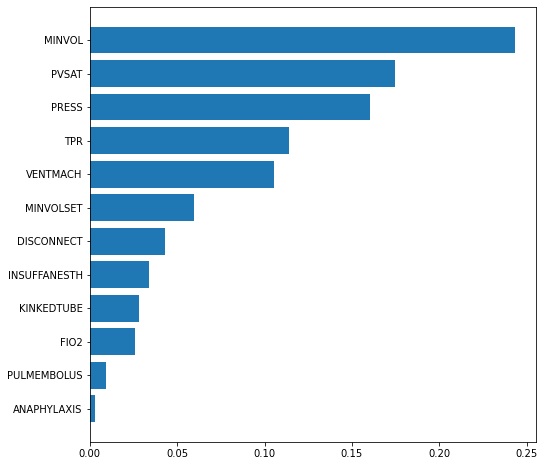

In [ ]:
# Adaboost Testing
y_pred = model1.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
importances = model.feature_importances_
import matplotlib.pyplot as plt
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 8))

ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [ ]:
# RF Training
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

clf = RandomForestClassifier(n_estimators = 1000,random_state=49,class_weight='balanced')  
model = clf.fit(X_train, y_train)

ACCURACY OF RANDOM FOREST THE MODEL:  0.749
              precision    recall  f1-score   support

           0       0.69      0.76      0.72        50
           1       0.85      0.74      0.79       545
           2       0.70      0.84      0.76       366
           3       0.00      0.00      0.00        39

    accuracy                           0.75      1000
   macro avg       0.56      0.59      0.57      1000
weighted avg       0.75      0.75      0.75      1000



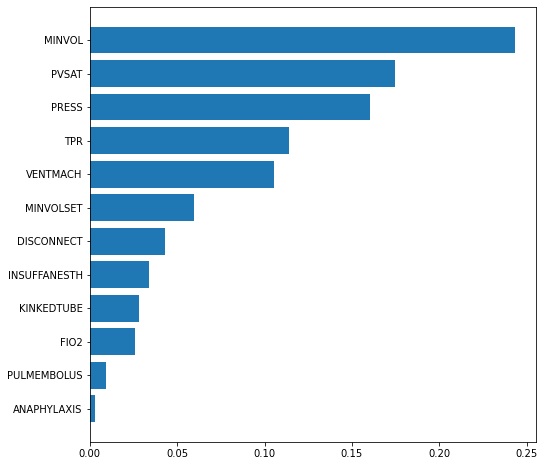

In [ ]:
# RF Testing
y_pred = model.predict(X_test)
  
print("ACCURACY OF RANDOM FOREST THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
importances = model.feature_importances_
importances
import matplotlib.pyplot as plt
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

############ REGRESSION

In [ ]:
# ALARM DATASET

# Training data 1 domain
df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_train1.csv")



n_examples_task = 500
n_tasks = 2
n_test_tasks = 1
n_predictors = 21
n_ex = []

for i in range(n_tasks):
    n_ex.append(n_examples_task)


n_ex = np.array(n_ex)

## Taking ARTCO2 as target
# train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df.drop(["ACO2"], axis = 1 ), df["ACO2"], n_ex,0.5)

## Taking EXPCO2 as target
train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df.drop(["ECO2"], axis = 1 ), df["ECO2"], n_ex,0.5)

In [ ]:
# ALARM DATASET

# Training data + soft INT as  training
df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_train1.csv")


df2 = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_softINT2.csv")

df2 = df2.append(df)

n_examples_task = 1000
n_tasks = 2
n_test_tasks = 1
n_predictors = 21
n_ex = []

for i in range(n_tasks):
    n_ex.append(n_examples_task)


n_ex = np.array(n_ex)

## Taking ARTCO2 as target
# train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df2.drop(["ACO2"], axis = 1 ), df2["ACO2"], n_ex,0.5)

## Taking EXPCO2 as target
train_x, train_y, valid_x, valid_y, n_ex_train, n_ex_valid = split_train_valid(df2.drop(["ECO2"], axis = 1 ), df2["ECO2"], n_ex,0.5)

In [ ]:
import numpy as np
import scipy as sp
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
import itertools
import sys

use_hsic = False 
delta = 0.05

num_s = np.sum(n_ex)

num_predictors = train_x.shape[1]
best_subset = np.array([])
best_subset_acc = np.array([])
best_mse_overall = 1e10

already_acc = False

selected = np.zeros(num_predictors)
accepted_subset = None

all_sets, all_pvals = [], []


n_iters = 10*num_predictors
stay = 1

pow_2 = np.array([2**i for i in np.arange(num_predictors)])

ind = 0
prev_stat = 0

bins = []

#Get numbers for the mean

pred = np.mean(train_y)
mse_current = np.mean((pred - valid_y) ** 2)
residual = valid_y - pred
 #   residTup = np.array(residTup).flatten()
residTup = levene_pval(residual,n_ex_valid,n_ex_valid.size)

levene = sp.stats.levene(*residTup)

all_sets.append(np.array([]))
all_pvals.append(levene[1])

alpha = 0.05

if all_pvals[-1]>alpha:
  accepted_subset = np.array([])

while (stay==1):
    
    pvals_a = np.zeros(num_predictors)
    statistic_a = 1e10 * np.ones(num_predictors)
    mse_a = np.zeros(num_predictors)
    
    for p in range(num_predictors):
        current_subset = np.sort(np.where(selected == 1)[0])
        regr = linear_model.LinearRegression()
        
        if selected[p]==0:
            subset_add = np.append(current_subset, p).astype(int)
            regr.fit(train_x[:,subset_add], train_y.flatten())
            
            pred = regr.predict(valid_x[:,subset_add])[:,np.newaxis]
            mse_current = np.mean((pred - valid_y)**2)
            residual = (np.array(valid_y).flatten() - np.array(pred).flatten())
            
            residTup = levene_pval(residual,n_ex_valid,
                                                 n_ex_valid.size)
            # print(residual.shape)
            levene = sp.stats.levene(*residTup)
            
            pvals_a[p] = levene[1]
            statistic_a[p] = levene[0]
            mse_a[p] = mse_current
            
            all_sets.append(subset_add)
            all_pvals.append(levene[1])
        
        if selected[p] == 1:
            acc_rem = np.copy(selected)
            acc_rem[p] = 0
            
            subset_rem = np.sort(np.where(acc_rem == 1)[0])
            
            if subset_rem.size ==0: continue
            
            regr = linear_model.LinearRegression()
            regr.fit(train_x[:,subset_rem], train_y.flatten())
            
            pred = regr.predict(valid_x[:,subset_rem])[:,np.newaxis]
            mse_current = np.mean((pred - valid_y)**2)
            residual = (np.array(valid_y).flatten() - np.array(pred).flatten())
            
            residTup = levene_pval(residual,n_ex_valid, 
                                                 n_ex_valid.size)
            levene = sp.stats.levene(*residTup)
            
            pvals_a[p] = levene[1]
            statistic_a[p] = levene[0]
            mse_a[p] = mse_current
            
            all_sets.append(subset_rem)
            all_pvals.append(levene[1])
    
    accepted = np.where(pvals_a > alpha)
    
    if accepted[0].size>0:
        best_mse = np.amin(mse_a[np.where(pvals_a > alpha)])
        already_acc = True
        
        selected[np.where(mse_a == best_mse)] = \
          (selected[np.where(mse_a == best_mse)] + 1) % 2
        
        accepted_subset = np.sort(np.where(selected == 1)[0])
        binary = np.sum(pow_2 * selected)
        
        if (bins==binary).any():
            stay = 0
        bins.append(binary)
    else:
        best_pval_arg = np.argmin(statistic_a)
        
        selected[best_pval_arg] = (selected[best_pval_arg] + 1) % 2
        binary = np.sum(pow_2 * selected)
        
        if (bins==binary).any():
            stay = 0
        bins.append(binary)
    
    if ind>n_iters:
        stay = 0
    ind += 1


if accepted_subset is None:
  all_pvals = np.array(all_pvals).flatten()
  
  max_pvals = np.argsort(all_pvals)[-1]
  accepted_subset = np.sort(all_sets[max_pvals])

In [ ]:
print(accepted_subset)
print(accepted)

[9]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17,
       18, 19, 20]),)


In [ ]:
df2.drop(['ECO2'], axis=1)
# df2.drop(['ACO2'], axis=1)

,PMB,INT,DISC,KINK,MVS,FIO2,APL,ANES,SHNT,PAP,TPR,VMCH,VTUB,PRSS,VLNG,VALV,MINV,ACO2,PVS,SAO2,CCHL
0,9.634172,2.092500,-0.820810,-1.655160,0.023484,-1.173725,-1.367037,-0.865120,2.892519,38.734281,-2.761450,0.648474,-3.203860,-14.032993,-14.178243,-73.866562,-8.245791,-738.570604,150.291648,78.226727,-5606.616034
1,9.407365,2.065089,-0.897676,-1.219134,-0.099184,-0.968851,-2.407337,-1.043939,2.896333,37.207914,-4.739510,0.755557,-3.883371,-12.419035,-12.773126,-65.575416,-6.760452,-655.917825,134.135415,68.908152,-4989.128290
2,9.707179,2.550885,-0.512960,-0.849870,-0.265847,-0.794231,-0.535513,-0.989653,5.662722,38.785668,-0.810877,1.241027,-5.231297,-13.205503,-13.019669,-64.076344,-5.682553,-640.500168,131.640330,70.093936,-4849.138081
3,9.750950,2.240138,-1.344655,-1.957273,-0.104020,-0.863502,-2.021747,-0.922381,3.611668,39.626073,-4.349381,1.441020,-6.378893,-17.544519,-16.945620,-90.503496,-11.313400,-904.509154,187.639977,96.551917,-6864.874160
4,9.983332,2.175081,-0.925939,-1.882428,0.346551,-1.065333,-1.693710,-0.898171,3.048958,39.472825,-3.493447,-1.936263,6.007108,-12.138160,-11.940216,-59.828340,-5.917730,-598.193593,122.654385,64.099181,-4542.361825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.524596,2.233616,-0.669905,-0.808229,0.042524,-0.953088,-1.668014,-1.114540,3.742804,38.483443,-3.526491,-1.088850,3.204424,-8.018281,-8.938673,-41.193547,-2.521904,-412.137627,83.153174,44.039346,-3135.449345
996,10.478096,2.294868,-0.910423,-2.051726,0.197059,-1.212614,-1.540881,-0.842339,2.977651,42.376400,-4.374108,-1.063981,3.193246,-13.632071,-13.675745,-69.785635,-7.381488,-697.701584,141.197799,72.550625,-5307.112625
997,9.684723,2.280479,-0.906028,-1.609548,0.218766,-1.103314,-1.745732,-1.066011,4.090774,38.631212,-3.735848,-0.797485,2.160329,-12.633280,-11.982887,-59.959497,-5.866067,-599.747697,122.479700,64.008062,-4556.678718
998,9.821713,2.358176,-1.377481,-1.150242,0.163891,-1.024320,-1.977978,-0.878067,4.599022,39.791838,-4.199573,-0.181273,-0.987667,-11.537396,-11.954768,-58.417405,-5.129136,-584.008670,120.047792,64.695906,-4429.359071


Baselines

In [ ]:
# ALARM 
# # Training data 1 domain
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_train1.csv")


# # # TRAINING + SOFT INT DATA

df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_train1.csv")

df2 = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_softINT2.csv")

df2 = df2.append(df)
df = df2

# # ECO2 TARGET
# X_train,X_test,y_train,y_test = train_test_split(df['ANES'], df['ECO2'],test_size=0.2)
X_train,X_test,y_train,y_test = train_test_split(df['PAP'], df['ECO2'],test_size=0.2)

X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# # ACO2 TARGET
# X_train,X_test,y_train,y_test = train_test_split(df['ANES'], df['ACO2'],test_size=0.2)
# X_train,X_test,y_train,y_test = train_test_split(df['PAP'], df['ACO2'],test_size=0.2)

# X_train = X_train.values.reshape(-1,1)
# X_test = X_test.values.reshape(-1,1)


In [ ]:
# ALARM TESTING DATA

# ACO2 TARGET

# # Testing Data 8 -> Soft Int2
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_softINT2.csv")

# # X_test = df['ANES']
# X_test = df['PAP']
# X_test = X_test.values.reshape(-1,1)

# y_test = df['ACO2']

# # Testing Data 9 -> Hard Int2
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_hardINT2.csv")

# # X_test = df['ANES']
# X_test = df['PAP']
# X_test = X_test.values.reshape(-1,1)

# y_test = df['ACO2']

# ECO2 TARGET

# # Testing Data 8 -> Soft Int2
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_softINT2.csv")

# # X_test = df['ANES']
# X_test = df['PAP']
# X_test = X_test.values.reshape(-1,1)

# y_test = df['ECO2']

# Testing Data 9 -> Hard Int2
df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_hardINT2.csv")

# X_test = df['ANES']
X_test = df['PAP']
X_test = X_test.values.reshape(-1,1)

y_test = df['ECO2']


In [ ]:
# Adaboost train
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score

regressor1 = AdaBoostRegressor(n_estimators=1000, random_state=49)
regressor1.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=1000, random_state=49)

In [ ]:
# Adaboost Testing
y_pred = regressor1.predict(X_test) 
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred )
print("Mean squared error =", round(mse, 2))

Mean Absolute Error: 1517.35
Mean squared error = 3269846.97


In [ ]:
# RF Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score

regressor = RandomForestRegressor(n_estimators = 1000,random_state=49)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=49, verbose=0, warm_start=False)

In [ ]:
# RF Testing
y_pred = regressor.predict(X_test) 
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred )
print("Mean squared error =", round(mse, 2))

Mean Absolute Error: 1667.98
Mean squared error = 4081827.82
